# COVID-19 Spread Toy Example
## Initilization Anchored NN Ensemble Sanity Check


In this notebook I want to demonstrate that my tensorflow implementation of the ensemble neural network is actually working and useful. In the spirit of times, I will try to learn the _hypothetical_ spreading of the COVID-19 disease in the _hypothetical_ island of Wakanda through the period of one year.

In [1]:
from simba.infrastructure import MLPEnsemble, InitializationAnchoredNN
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
tf.set_random_seed(0)
np.random.seed(0)

/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-

First we generate some data using the [SIR model](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html) of covid19: 

In [2]:
def generate_covid_19_infection_rate_data():
    # https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
    # https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
    population = 15000
    days = 365
    i_0, r_0 = 2, 0
    s_0 = population - i_0 - r_0
    beta, gamma = 0.3, 0.02
    t = np.linspace(0, days, days)

    def deriv(y, t, population, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / population
        dIdt = beta * S * I / population - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    y_0 = s_0, i_0, r_0
    ret = odeint(deriv, y_0, t, args=(population, beta, gamma))
    _, infected_people, _ = ret.transpose()
    return t, infected_people

Say we have only have access to noisy measurements of how many people were sick on a certain day: 

In [3]:
time, infected_people = generate_covid_19_infection_rate_data()
n_samples = 25
noise = 0.01
time_augmented = np.array([])
infected_people_samples = np.array([])
for day, sick_people_that_day in zip(time, infected_people):
    time_augmented = np.append(time_augmented, np.full(n_samples, day))
    infected_people_samples = np.append(infected_people_samples, np.random.normal(
    sick_people_that_day, noise * sick_people_that_day, n_samples))
time_val = np.linspace(0, 365, 900)

In [4]:
# Some hyperparameters
def make_model(sess):
    mlp_dict = dict(
        learning_rate=0.0007,
        n_layers=5,
        hidden_size=64,
        activation=tf.nn.relu,
        anchor=False,
        init_std_bias=10.0,
        init_std_weights=10.5,
        data_noise=noise
    )
    return MLPEnsemble(
        sess=sess,
        inputs_dim=1,
        outputs_dim=1,
        ensemble_size=5,
        n_epochs=200,
        batch_size=256,
        **mlp_dict
    )

Run the training loop:

In [5]:
tf.reset_default_graph()

In [6]:
n_particles = 20
x_test = np.broadcast_to(time_val, (n_particles, time_val.shape[0]))
x_test = np.reshape(x_test, (n_particles * time_val.shape[0]))
data_mean = time_augmented.mean()
data_std = time_augmented.std()
x = np.squeeze((time_augmented - data_mean) / (data_std + 1e-8))
x_test = (x_test - data_mean) / (data_std + 1e-8)
with tf.Session() as sess:
    model = make_model(sess)
    sess.run(tf.global_variables_initializer())
    model.fit(x[:, np.newaxis], infected_people_samples[:, np.newaxis])
    mus, sigmas, preds = np.squeeze(model.predict(x_test[:, np.newaxis]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Epoch  0  | Losses = [4048017.2 1383573.5 2051451.2 2889776.5 1915667.1]
[-9.983166] [5.822093] fldkldfklf
Epoch  20  | Losses = [53.68555  59.416702 61.942486 65.081474 64.28493 ]
[-9.980987] [5.8384686] fldkldfklf
Epoch  40  | Losses = [21.86989  23.4325   26.898361 54.17117  28.028978]
[-9.980987] [5.8450713] fldkldfklf
Epoch  60  | Losses = [10.796741 22.510876 18.620056 18.837381 19.81343 

The total uncertainty (epistemic and aleatoric) using monte-carlo estimation using data sampled from _ensemble_size_ and _n\_particles_ 

In [7]:
# For more details on decomposition of uncertainties: http://proceedings.mlr.press/v80/depeweg18a/depeweg18a.pdf 
preds = np.reshape(preds, 
                  (model.ensemble_size, n_particles, time_val.shape[0]))
aleatoric_monte_carlo_uncertainty = np.mean(np.std(preds, axis=1) ** 2, axis=0)
epistemic_monte_carlo_uncertainty = np.std(np.mean(preds, axis=1), axis=0) ** 2
total_monte_carlo_uncertainty = aleatoric_monte_carlo_uncertainty + epistemic_monte_carlo_uncertainty

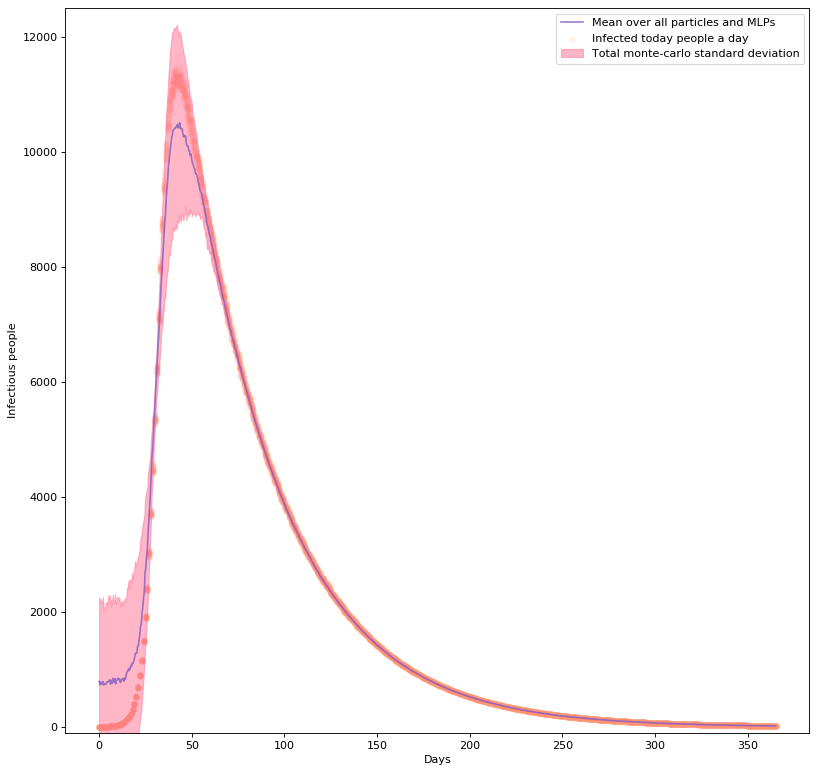

In [8]:
fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.subplots()
ax.set_ylim([-100, 12.5e3])
ax.scatter(time_augmented, infected_people_samples, color='#FF9671', alpha=0.09,
           s=20, label='Infected today people a day')
ax.plot(time_val, np.mean(preds, axis=(0, 1)), '-', color='#845EC2', linewidth=1.5, 
       label='Mean over all particles and MLPs', alpha=0.8)
ax.fill_between(time_val, np.mean(preds, axis=(0, 1)) - np.sqrt(total_monte_carlo_uncertainty),
                np.mean(preds, axis=(0, 1)) + np.sqrt(total_monte_carlo_uncertainty),
                color='#FF6F91', alpha=0.5, label='Total monte-carlo standard deviation')
ax.legend(loc='upper right', fontsize='medium')
plt.xlabel("Days")
plt.ylabel("Infectious people")
plt.show()

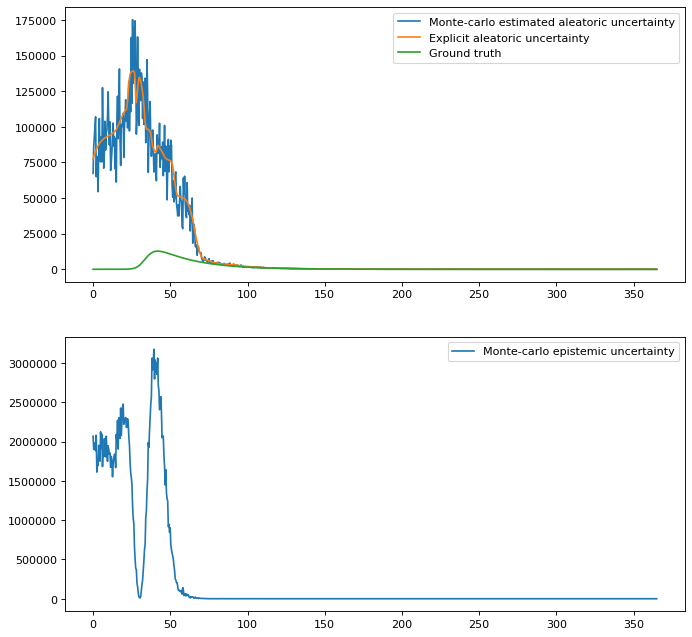

In [9]:
mus = np.reshape(mus, 
                  (model.ensemble_size, n_particles, time_val.shape[0]))
sigmas = np.reshape(sigmas, 
                  (model.ensemble_size, n_particles, time_val.shape[0]))
aleatoric_explicit_uncertainty = np.mean(sigmas ** 2, axis=(0, 1))
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(211)
ax1.plot(time_val, aleatoric_monte_carlo_uncertainty, label='Monte-carlo estimated aleatoric uncertainty')
ax1.plot(time_val, aleatoric_explicit_uncertainty, label='Explicit aleatoric uncertainty')
ax1.plot(time, (infected_people * noise) ** 2, label='Ground truth')
ax1.legend(loc='upper right', fontsize='medium')
ax2 = fig.add_subplot(212)
ax2.plot(time_val, epistemic_monte_carlo_uncertainty, label='Monte-carlo epistemic uncertainty')
ax2.legend(loc='upper right', fontsize='medium')